# Development of a condition monitoring system for wind turbine bearings using machine learning

# 1.0 Introduction

The wind energy technology can be considered as one of the most competitive technologies when it comes to renewable energy generation. It works around a center figure, the wind turbine, and their operations and maintenance (O&M) activities ins responsible for a great deal of its competitiveness, being responsible for around 30% of the overall cost of energy (LCOE). 

Nowadays, most of the wind turbines are monitored by SCADA (Supervisory Control and Data Aquisition) systems due to its ease of implementation and low cost. However, these systems present limitations related to lack of data (due to the discontinuity of data samples, which are usually taken in 10 min range) and lack of falt identification in sensors, for instance.

Therefore, extracting useful information from SCADA data can be powerful for building tools that can predict the behavior of wind turbine components, and that's where Data Science can come in to play.

In order to do that, this notebook is part of a master's thesis aiming at testing different machine learning algorithms with SCADA data in order to create a Condition Monitoring System that can be useful for the Brazilian wind energy companies. The chosen methods and components to be monitored are the result of an extensive systematic literature review as well as interviews with O&M specialists of wind power plants. Section two of the notebook will go deeper on the methodology, section three...

# 2.0 Research Method

The research method of the Thesis follows the scheme presented in the following Figure 1:

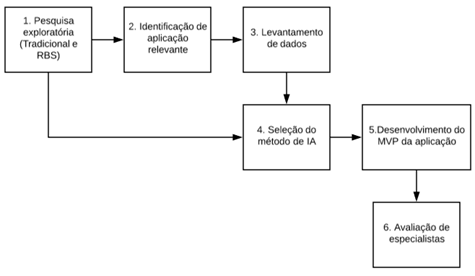
First off all, it was performed a systematic literature review using the Periodicos Capes platform. As a result, it was found 51 articles related to the themes Wind Energy, Operations and Maintenance and Artificial Intelligence. These articles were then analyzed in order to extract the best results, methods and Wind turbine components that were the object of these articles.

By having this analysis completed, we presented it to an O&M Wind Farm specialist, in order to find out which applications could be useful in the Brazilian wind farms context. In this interview/conversation, it was clear that the bearing was the biggest concern of the specialist because they usually fail without warning. In other words, a CMS for wind turbine bearings would be a good fit in the expert's opinion.

In this sense, we searched for the best results related to bearings inside the systematic literature review analysis and found that the method presented in Schleichtingen and Santos (2011) had the best results in early detection of faults in wind turbine generator and gearbox bearings. Also, we discussed with the expert if it would about the availability of Data for developing this research, coming to the conclusion that it would be available.

Therefore, the purpose of this notebook is to develop the method presented by Schaleichtingen e Santos (2011) with SCADA data from a Brazilian Wind Farm. Also, we are going to try to improve it adding some up to date methods.

### 2.1 Pipeline

This notebook aims at follow the pipeline presented in the Figure:

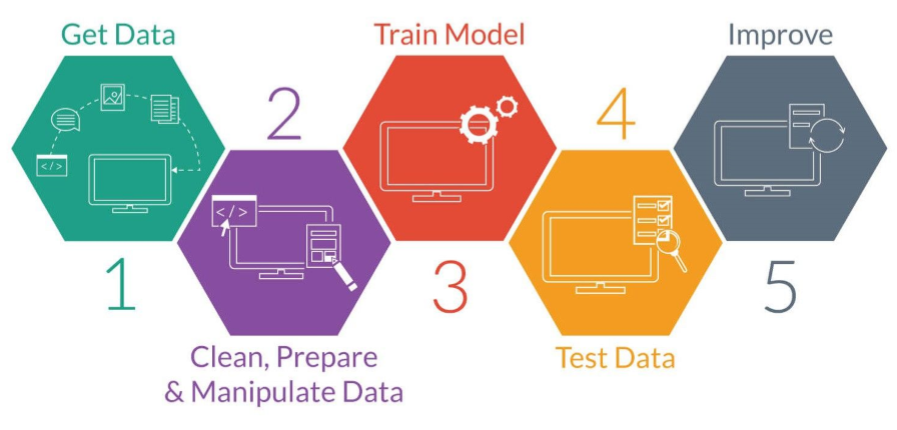

# 3.0 Geting Data

The data we are going to use for building this project is offered from a SCADA system of wind turbines located in Brazil using the same measures of Schleichtingen e Santos (2011). We collected data from more than 90 wind turbines from the same wind farm. The data was collected from since the beggining of this wind farm operations, in 2011, ending in 2019. At first, we are going to use the SCADA data from wind turbine 36, because it had problems related to bearings and it will be used for model validating purposes.

## 3.1 Taking a quick look at the data

In [64]:
import pandas as pd

df = pd.DataFrame(pd.read_excel('AEG 36.xlsx'))
print(df.head())

            Date/Time  A2WTG36_Avr.nacelle temp.°C (67)  \
0 2011-01-01 00:00:00                               NaN   
1 2011-01-01 00:10:00                               NaN   
2 2011-01-01 00:20:00                               NaN   
3 2011-01-01 00:30:00                               NaN   
4 2011-01-01 00:40:00                               NaN   

   A2WTG36_Avr.gen.speed,RPM (67)  A2WTG36_Avr.W1 temp.large gen.°C (67)  \
0                             NaN                                    NaN   
1                             NaN                                    NaN   
2                             NaN                                    NaN   
3                             NaN                                    NaN   
4                             NaN                                    NaN   

   A2WTG36_Avr.W2 temp.large gen.°C (67)  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3           

In [65]:
#Renaming the colunms in a more comprehensive way

cols = ['Date/Time', 
        'Nacelle Temp(°C)', 
        'Generator Spd(RPM)',
        'Winding1 Temp(°C)',
        'Winding2 Temp(°C)',
        'Winding3 Temp(°C)',
        'Active Power(kW)',
        'Gearbox oil Temp(°C)',
        'Amb Temp(°C)',
        'Gen Bearing Temp(°C)',
        'Gear Bearing Temp(°C)',
        'Winding avg temp(°C)']

df.columns = cols

df.head()

Date/Time  Nacelle Temp(°C)  Generator Spd(RPM)  \
0 2011-01-01 00:00:00               NaN                 NaN   
1 2011-01-01 00:10:00               NaN                 NaN   
2 2011-01-01 00:20:00               NaN                 NaN   
3 2011-01-01 00:30:00               NaN                 NaN   
4 2011-01-01 00:40:00               NaN                 NaN   

   Winding1 Temp(°C)  Winding2 Temp(°C)  Winding3 Temp(°C)  Active Power(kW)  \
0                NaN                NaN                NaN               NaN   
1                NaN                NaN                NaN               NaN   
2                NaN                NaN                NaN               NaN   
3                NaN                NaN                NaN               NaN   
4                NaN                NaN                NaN               NaN   

   Gearbox oil Temp(°C)  Amb Temp(°C)  Gen Bearing Temp(°C)  \
0                   NaN           NaN                   NaN   
1                   NaN           NaN                   NaN   
2                   NaN           NaN                   NaN   
3                   NaN           NaN                   NaN   
4                   NaN           NaN                   NaN   

   Gear Bearing Temp(°C)  Winding avg temp(°C)  
0                    NaN                   NaN  
1                    NaN                   NaN  
2                    NaN                   NaN  
3                    NaN                   NaN  
4                    NaN                   NaN

From the table, each row represents a data instance collected from SCADA, and each column represent its nature. The data was taken according to the following figure presented by Schleichtingen and Santos (2011):
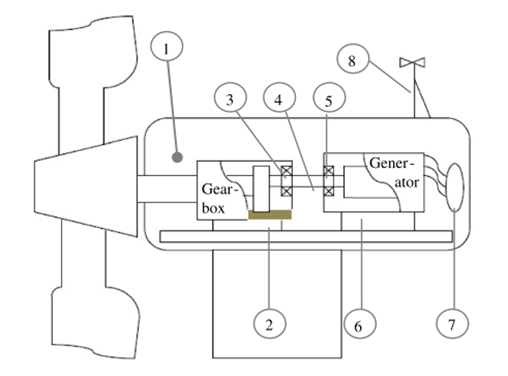

- **Nacele Temp(°C):** Represents da Nascelle temperature in °C (1);
- **Generator Spd(RPM):** The gen shaft speed in RPM (4);
- **Winding(1, 2 and 3) Temp(°C):** Gen whirling temperature of each phase in °C;
- **Winding avg temp(°C)(°C)**: Average gen whirling temperature in °C (6);
- **Active Power(kW):** Intant Power output in KW (7);
- **Gearbox oil Temp(°C):** Gearbox oil temperature in °C (2);
- **Amb Temp(°C)**: Ambient temperature in °C (8);
- **Gen Bearing Temp(°C):** Generator bearing temperature in °C **[Target]** (3);
- **Gear Bearing Temp(°C):** Gearbox bearing temperature in °C **[Target]** (5);


In [66]:
# Using info to get particular description of the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450391 entries, 0 to 450390
Data columns (total 12 columns):
Date/Time                450061 non-null datetime64[ns]
Nacelle Temp(°C)         322467 non-null float64
Generator Spd(RPM)       322623 non-null float64
Winding1 Temp(°C)        322653 non-null float64
Winding2 Temp(°C)        322785 non-null float64
Winding3 Temp(°C)        322797 non-null float64
Active Power(kW)         322753 non-null float64
Gearbox oil Temp(°C)     322362 non-null float64
Amb Temp(°C)             290752 non-null float64
Gen Bearing Temp(°C)     322605 non-null float64
Gear Bearing Temp(°C)    322461 non-null float64
Winding avg temp(°C)     322773 non-null float64
dtypes: datetime64[ns](1), float64(11)
memory usage: 41.2 MB


From the information above, one can see that the data contains 450390 entries in total, however, there are alot of missing values since the attributes have around 322000 non-null values. Also, the Ambiente Temp attribute has even lower entries (around 290000).

In order to meet machine learning standards all columns must have the same amount of data entries, therefore, we have to take care of this latter on.

In [67]:
# showing a summary of the numerical atributes

df.describe()

Nacelle Temp(°C)  Generator Spd(RPM)  Winding1 Temp(°C)  \
count      322467.00000       322623.000000      322653.000000   
mean           37.85369         1141.764803          71.571493   
std             2.45555          230.789868          18.645798   
min             0.00000            0.000000           0.000000   
25%            37.00000         1201.000000          61.000000   
50%            37.00000         1202.000000          65.000000   
75%            38.00000         1205.000000          78.000000   
max            59.00000         1218.000000         150.000000   

       Winding2 Temp(°C)  Winding3 Temp(°C)  Active Power(kW)  \
count      322785.000000      322797.000000     322753.000000   
mean           71.575321          71.779211        512.208923   
std            18.140870          18.853843        466.255927   
min             0.000000           0.000000        -41.300000   
25%            61.000000          61.000000        127.800000   
50%            66.000000          65.000000        387.400000   
75%            78.000000          78.000000        789.400000   
max           149.000000         147.000000       1676.900000   

       Gearbox oil Temp(°C)   Amb Temp(°C)  Gen Bearing Temp(°C)  \
count         322362.000000  290752.000000         322605.000000   
mean              52.815515      30.460214             62.315643   
std                2.395337       3.030850              9.115885   
min                0.000000       0.000000              0.000000   
25%               52.000000      28.000000             57.000000   
50%               53.000000      30.000000             60.000000   
75%               54.000000      32.000000             66.000000   
max               62.000000     225.000000            119.000000   

       Gear Bearing Temp(°C)  Winding avg temp(°C)  
count          322461.000000         322773.000000  
mean               58.011803             72.177434  
std                 3.247019             19.016808  
min                 0.000000              0.000000  
25%                58.000000             61.000000  
50%                58.000000             66.000000  
75%                59.000000             78.000000  
max                87.000000            150.000000

## 3.2 Histogram

In order to get a feel of the data and see how it behaves, we ploted a histogram for each numerical attribute of the dataset:

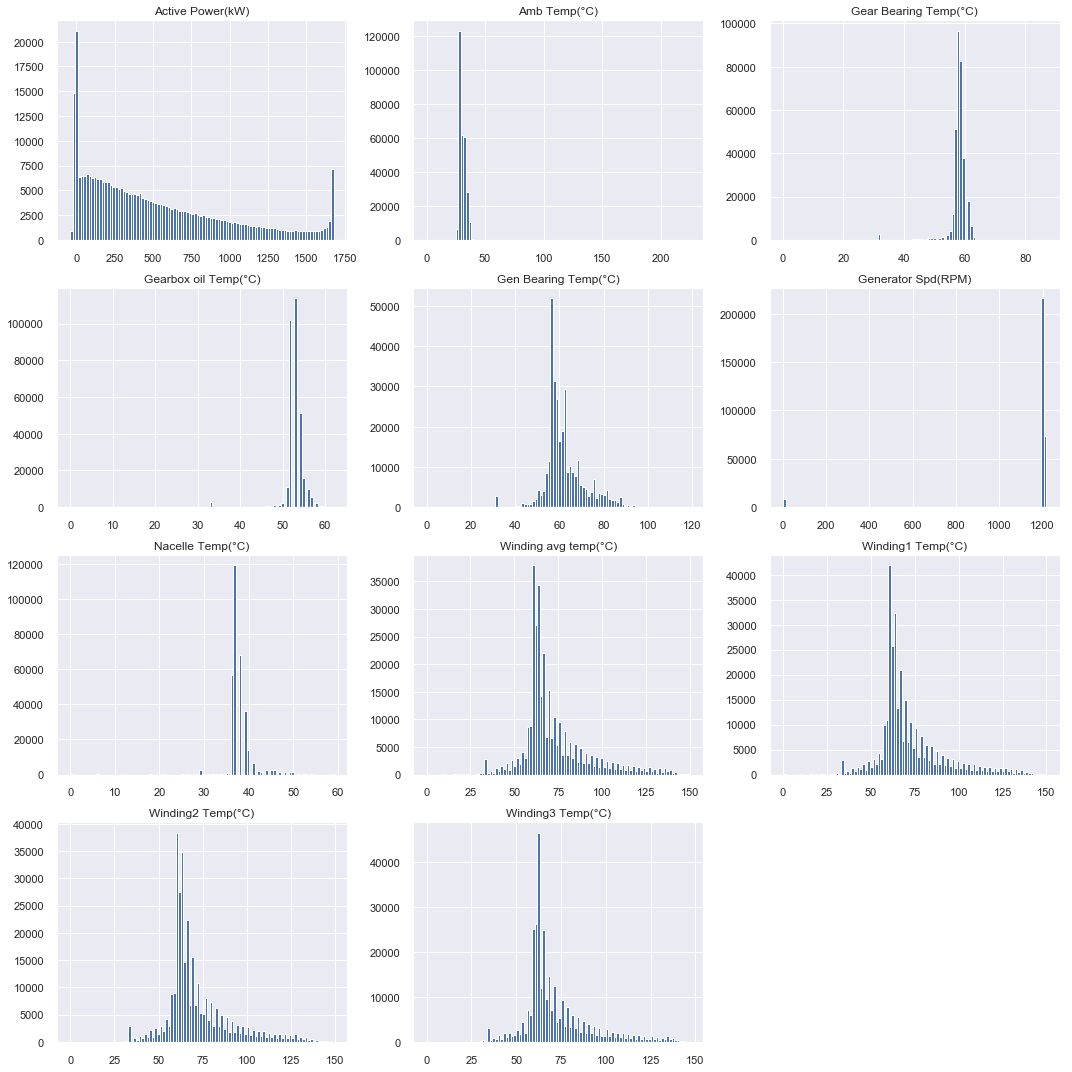

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline  
df.hist(bins=100, figsize=(15,15))
plt.tight_layout()
plt.show()

A bit discussion about the data behaviour:

- **Active Power(kW):** The Active Power (or Power Output) varies much more than the others, wich is expected because it depends on climatic attributes such as wind speed. It also have some peak values which may be caused by outliers. These outliers may be caused by tests when the turbine is put under extreme working condition in order to get tested.
- **Ambient Temp(°C), Nacelle Temp(°C)**: Do not vary much and are similar, as the Nacelle Temperature depends most on Ambient Temperature which does not varies much due to the climate conditions of the region where the wind farm is placed, which does maintains almost the same in the northeast region of Brazil. 
- **Gearbox oil Temp(°C):** The Gearbox Oil Temperature does not vary much as well. It serves as lubricant a coolant for the gearbox system and, as it is not near any type of combustion system, is expected to stay still at at the same Temperature.
- **Generator Spd(RPM):** The generator is set to work in a similar velocity when the turbine is working, therefore it is expected to have low variance in working conditions and zero velocity for when the turbine is not working.
- **Windding Temperature(°C):** The winding temperature varies with the current because of the Jaule efect. It is expected to have high variance, because the current also varies a lot.
- **Gen Bearing Temp(°C), Gear Bearing Temp(°C):** The gearbox bearing temperature have much bigger variance than the generator bearing temperature even though they have almost the same mean value.


## 3.3 Dividing data according to the article

In order to model the generator and gearbox bearing temperatures, the work presented by Schleichtingen e Santos (2011) used different data for each component, as shows the following table:

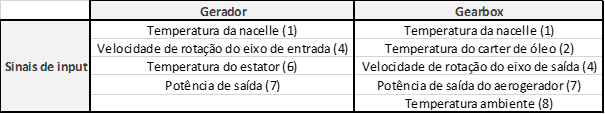

Therefore, data will be separated into gearbox and generator datasets to be analysed independently.

In [69]:
gear_cols = ['Date/Time','Nacelle Temp(°C)','Amb Temp(°C)','Gearbox oil Temp(°C)',
             'Generator Spd(RPM)','Active Power(kW)','Gear Bearing Temp(°C)']

gen_cols = ['Date/Time','Nacelle Temp(°C)','Winding avg temp(°C)','Active Power(kW)',
            'Generator Spd(RPM)','Gen Bearing Temp(°C)']

In [70]:
gear_df = df[gear_cols].copy()
gear_df.head()

Date/Time  Nacelle Temp(°C)  Amb Temp(°C)  Gearbox oil Temp(°C)  \
0 2011-01-01 00:00:00               NaN           NaN                   NaN   
1 2011-01-01 00:10:00               NaN           NaN                   NaN   
2 2011-01-01 00:20:00               NaN           NaN                   NaN   
3 2011-01-01 00:30:00               NaN           NaN                   NaN   
4 2011-01-01 00:40:00               NaN           NaN                   NaN   

   Generator Spd(RPM)  Active Power(kW)  Gear Bearing Temp(°C)  
0                 NaN               NaN                    NaN  
1                 NaN               NaN                    NaN  
2                 NaN               NaN                    NaN  
3                 NaN               NaN                    NaN  
4                 NaN               NaN                    NaN

In [71]:
import pandas_profiling
pandas_profiling.ProfileReport(gear_df)

In [72]:
gen_df = df[gen_cols].copy()
gen_df.head()

Date/Time  Nacelle Temp(°C)  Winding avg temp(°C)  \
0 2011-01-01 00:00:00               NaN                   NaN   
1 2011-01-01 00:10:00               NaN                   NaN   
2 2011-01-01 00:20:00               NaN                   NaN   
3 2011-01-01 00:30:00               NaN                   NaN   
4 2011-01-01 00:40:00               NaN                   NaN   

   Active Power(kW)  Generator Spd(RPM)  Gen Bearing Temp(°C)  
0               NaN                 NaN                   NaN  
1               NaN                 NaN                   NaN  
2               NaN                 NaN                   NaN  
3               NaN                 NaN                   NaN  
4               NaN                 NaN                   NaN

In [73]:
import pandas_profiling
pandas_profiling.ProfileReport(gen_df)

From the profile report of the datasets, one can see that in the missing values section, there are no huge gaps of missing that.

In [74]:
gear_df.corr()

Nacelle_Temp(°C)  Amb_Temp(°C)  Gearbox_oil_Temp(°C)  \
Nacelle_Temp(°C)               1.000000      0.220116              0.326780   
Amb_Temp(°C)                   0.220116      1.000000              0.166861   
Gearbox_oil_Temp(°C)           0.326780      0.166861              1.000000   
Generator_Spd(RPM)             0.215500      0.010969              0.616234   
Active_Power(kW)               0.191274      0.246410              0.418461   
Gear_Bearing_Temp(°C)          0.334741      0.143087              0.912382   

                       Generator_Spd(RPM)  Active_Power(kW)  \
Nacelle_Temp(°C)                 0.215500          0.191274   
Amb_Temp(°C)                     0.010969          0.246410   
Gearbox_oil_Temp(°C)             0.616234          0.418461   
Generator_Spd(RPM)               1.000000          0.305237   
Active_Power(kW)                 0.305237          1.000000   
Gear_Bearing_Temp(°C)            0.762682          0.374708   

                       Gear_Bearing_Temp(°C)  
Nacelle_Temp(°C)                    0.334741  
Amb_Temp(°C)                        0.143087  
Gearbox_oil_Temp(°C)                0.912382  
Generator_Spd(RPM)                  0.762682  
Active_Power(kW)                    0.374708  
Gear_Bearing_Temp(°C)               1.000000

In [75]:
gen_df.corr()

Nacelle_Temp(°C)  Winding_avg_temp(°C)  \
Nacelle_Temp(°C)              1.000000              0.286607   
Winding_avg_temp(°C)          0.286607              1.000000   
Active_Power(kW)              0.191274              0.855514   
Generator_Spd(RPM)            0.215500              0.332571   
Gen_Bearing_Temp(°C)          0.372817              0.882103   

                      Active_Power(kW)  Generator_Spd(RPM)  \
Nacelle_Temp(°C)              0.191274            0.215500   
Winding_avg_temp(°C)          0.855514            0.332571   
Active_Power(kW)              1.000000            0.305237   
Generator_Spd(RPM)            0.305237            1.000000   
Gen_Bearing_Temp(°C)          0.675823            0.388194   

                      Gen_Bearing_Temp(°C)  
Nacelle_Temp(°C)                  0.372817  
Winding_avg_temp(°C)              0.882103  
Active_Power(kW)                  0.675823  
Generator_Spd(RPM)                0.388194  
Gen_Bearing_Temp(°C)              1.000000

By seing the correlation analysis we found out that de Gearbox Oil Temperature is highly correlated with the Gearbox Bearing Temperature, what can affects our model. It is something that has to be analysed latter on.

Therefore, taking into account the method presented in Schleichtingen and Santos (2011) and this quick overview of data, the issues we are going to take care of for training our model are:

**1) Drop missing values;**

**2) Drop values under zero;**

**3) Drop outliers;**

**4) Test data with and without Gearbox oil temperature;**

## 3.4 Some more data interpretation graphs

### 3.4.1 For the gearbox

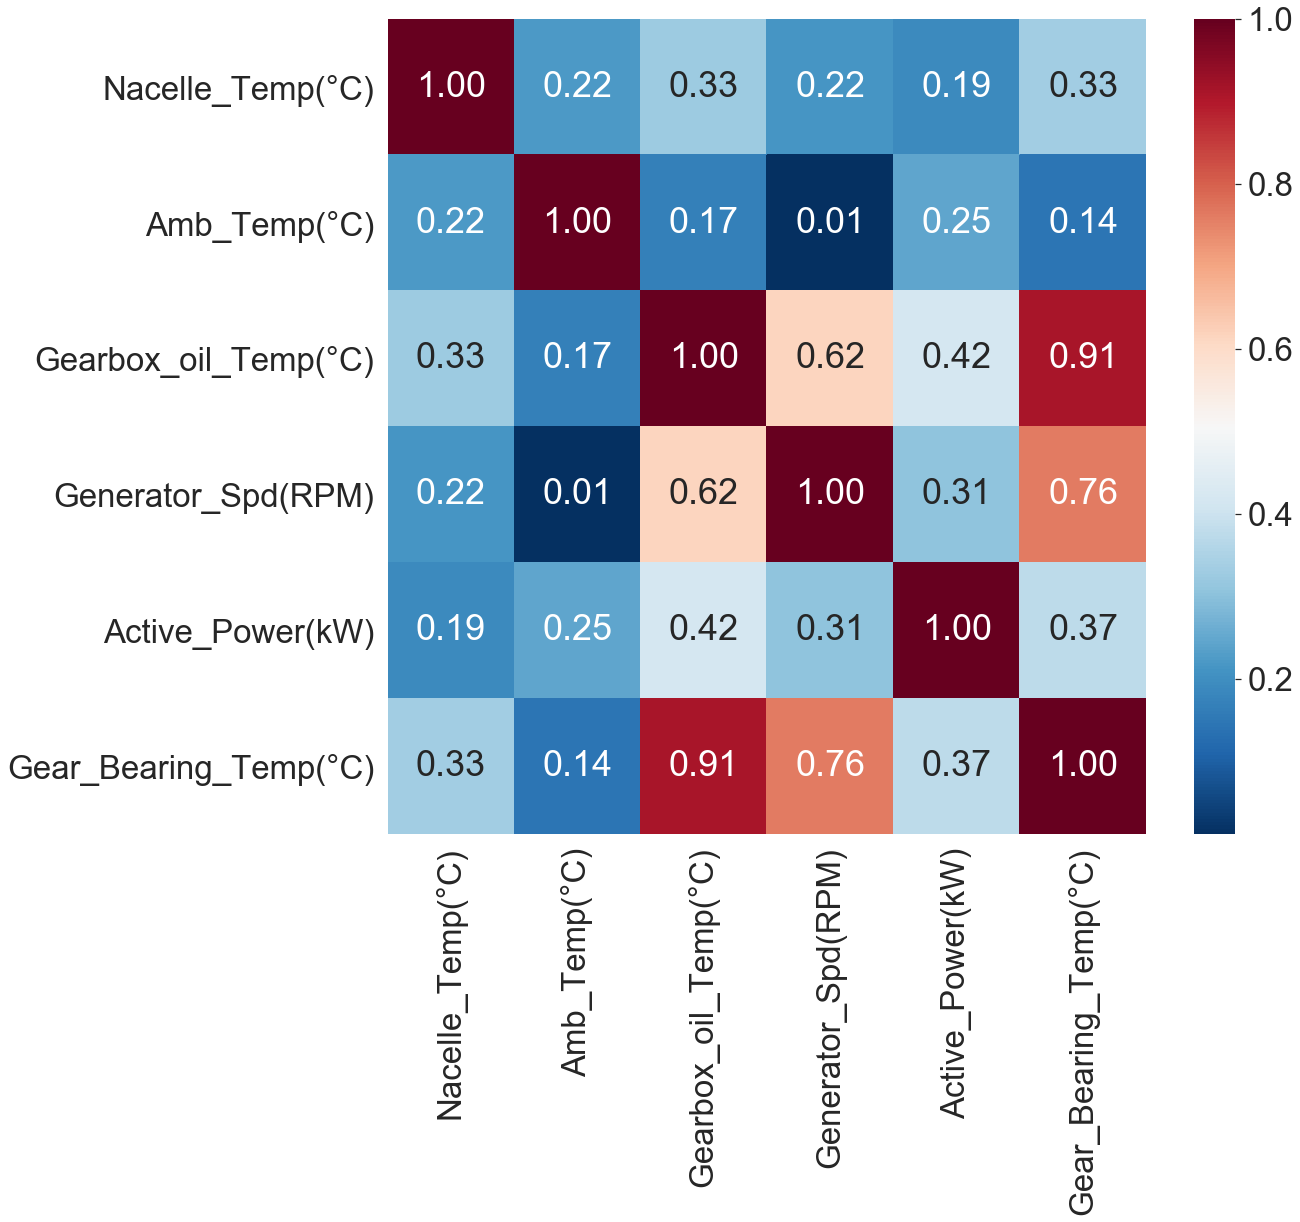

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=3.0)
plt.figure(figsize=(17, 15))
sns.heatmap(gear_df.corr(),
            annot=True, 
            fmt=".2f",
            cmap="RdBu_r",)

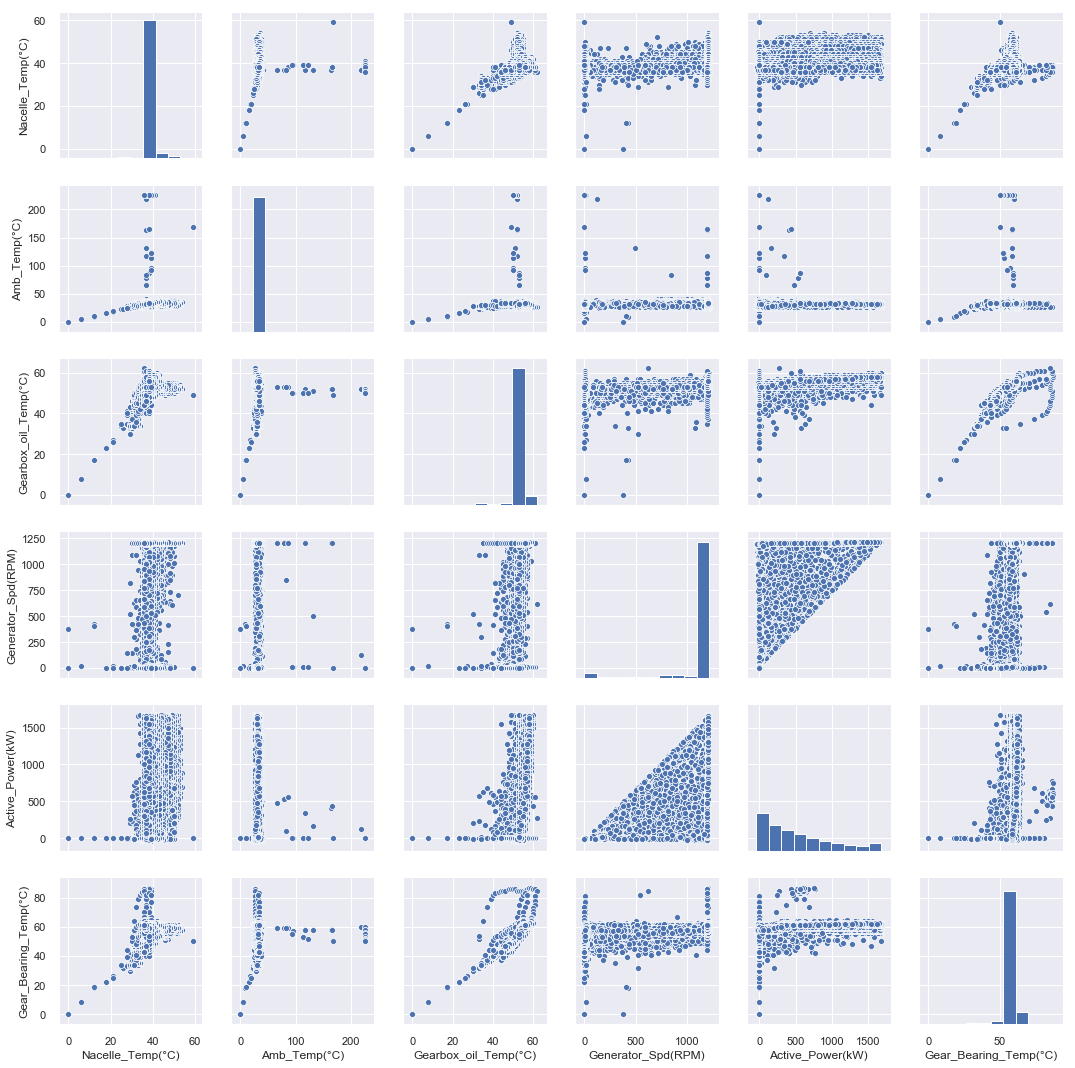

In [77]:
sns.set(font_scale=1.0)
sns.pairplot(gear_df, diag_kind='hist')

### 3.4.2 For the generator

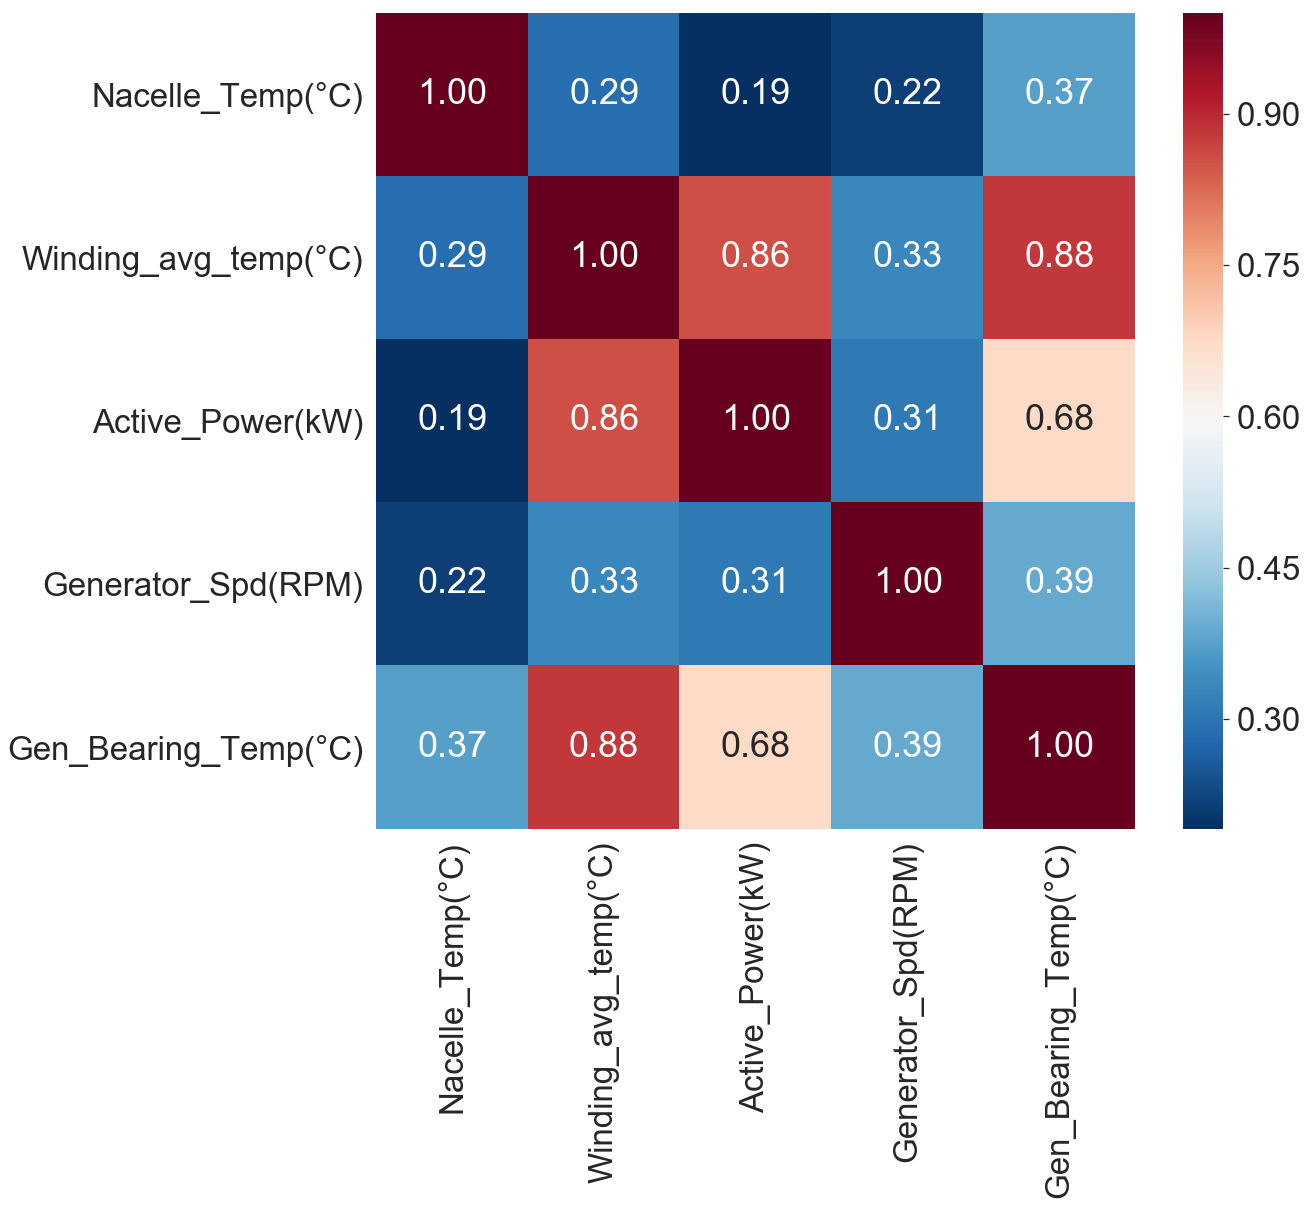

In [78]:
sns.set(font_scale=3.0)
plt.figure(figsize=(17, 15))
sns.heatmap(gen_df.corr(), 
            annot=True, 
            fmt=".2f",
            cmap="RdBu_r",)

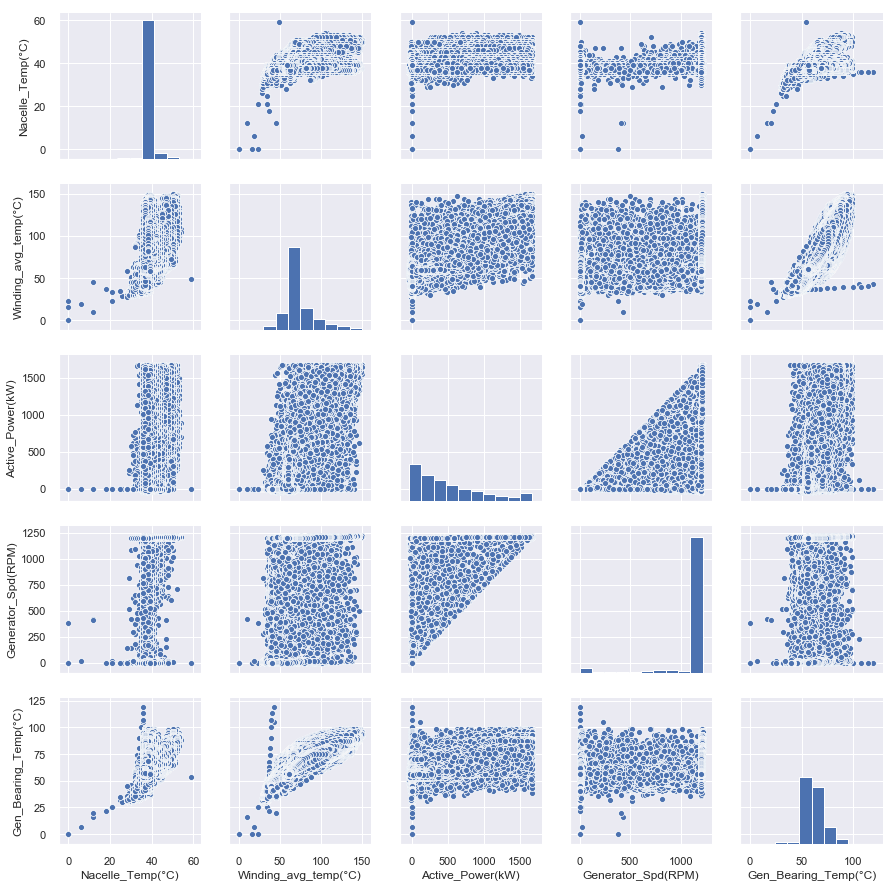

In [79]:
sns.set(font_scale=1)
sns.pairplot(gen_df, diag_kind='hist')

## 4.0 Prepare data for machine learning

### 4.1 Dropping missing values for the whole dataset

In [80]:
# Dorping missing values for the Gearbox dataset

gear_df = gear_df.dropna()

gear_df.head()

Date/Time  Nacelle_Temp(°C)  Amb_Temp(°C)  \
115734 2013-03-14 17:00:00              40.0          32.0   
115735 2013-03-14 17:10:00              40.0          31.0   
115736 2013-03-14 17:20:00              40.0          31.0   
115737 2013-03-14 17:30:00              40.0          31.0   
115738 2013-03-14 17:40:00              40.0          31.0   

        Gearbox_oil_Temp(°C)  Generator_Spd(RPM)  Active_Power(kW)  \
115734                  58.0              1212.0            1661.8   
115735                  58.0              1212.0            1634.3   
115736                  58.0              1212.0            1572.2   
115737                  58.0              1211.0            1506.8   
115738                  58.0              1211.0            1576.2   

        Gear_Bearing_Temp(°C)  
115734                   62.0  
115735                   62.0  
115736                   62.0  
115737                   61.0  
115738                   61.0

In [81]:
# Dorping missing values for the Generator dataset

gen_df = gen_df.dropna()

gen_df.head()

Date/Time  Nacelle_Temp(°C)  Winding_avg_temp(°C)  \
115734 2013-03-14 17:00:00              40.0                 127.0   
115735 2013-03-14 17:10:00              40.0                 127.0   
115736 2013-03-14 17:20:00              40.0                 128.0   
115737 2013-03-14 17:30:00              40.0                 128.0   
115738 2013-03-14 17:40:00              40.0                 126.0   

        Active_Power(kW)  Generator_Spd(RPM)  Gen_Bearing_Temp(°C)  
115734            1661.8              1212.0                  80.0  
115735            1634.3              1212.0                  80.0  
115736            1572.2              1212.0                  80.0  
115737            1506.8              1211.0                  80.0  
115738            1576.2              1211.0                  80.0

### 4.1 Creating train and test datasets

In Schleichtingen and Santos (2011), three months of data was used for training the neural network. The data considered for training was to be taken from the period from when the Wind Turbine is certanly working healthy, in order to build an accurate normal behaviour model. Therefore, the data used for training the model will be taken from the beggining of operation until 3 months of operation.

By seing that the operation of this Wind Turbine started in 2013-03-14, it is assumed that it will complete 3 months operation in 2014-06-15, therefore, it will be the endpoint of data for training.

In [82]:
date_training_end = '2013-06-15'

# train data for the gearbox

gear_df_train = gear_df[gear_df['Date/Time'] < date_training_end].copy()

gear_df_train.tail()

Date/Time  Nacelle_Temp(°C)  Amb_Temp(°C)  \
129019 2013-06-14 23:10:00              36.0          28.0   
129020 2013-06-14 23:20:00              36.0          28.0   
129021 2013-06-14 23:30:00              36.0          28.0   
129022 2013-06-14 23:40:00              36.0          28.0   
129023 2013-06-14 23:50:00              37.0          28.0   

        Gearbox_oil_Temp(°C)  Generator_Spd(RPM)  Active_Power(kW)  \
129019                  52.0              1200.0              22.2   
129020                  52.0              1200.0              39.1   
129021                  52.0              1200.0              -4.3   
129022                  52.0              1200.0              50.7   
129023                  53.0              1200.0              86.3   

        Gear_Bearing_Temp(°C)  
129019                   57.0  
129020                   57.0  
129021                   57.0  
129022                   57.0  
129023                   57.0

In [83]:
gear_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290752 entries, 115734 to 449940
Data columns (total 7 columns):
Date/Time                290752 non-null datetime64[ns]
Nacelle_Temp(°C)         290752 non-null float64
Amb_Temp(°C)             290752 non-null float64
Gearbox_oil_Temp(°C)     290752 non-null float64
Generator_Spd(RPM)       290752 non-null float64
Active_Power(kW)         290752 non-null float64
Gear_Bearing_Temp(°C)    290752 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 17.7 MB


In [84]:
# train data for the gearbox

gen_df_train = gen_df[gen_df['Date/Time'] < date_training_end].copy()

gen_df_train.tail()

Date/Time  Nacelle_Temp(°C)  Winding_avg_temp(°C)  \
129019 2013-06-14 23:10:00              36.0                  60.0   
129020 2013-06-14 23:20:00              36.0                  61.0   
129021 2013-06-14 23:30:00              36.0                  61.0   
129022 2013-06-14 23:40:00              36.0                  61.0   
129023 2013-06-14 23:50:00              37.0                  61.0   

        Active_Power(kW)  Generator_Spd(RPM)  Gen_Bearing_Temp(°C)  
129019              22.2              1200.0                  57.0  
129020              39.1              1200.0                  57.0  
129021              -4.3              1200.0                  57.0  
129022              50.7              1200.0                  57.0  
129023              86.3              1200.0                  58.0

In [85]:
gen_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322467 entries, 115734 to 450060
Data columns (total 6 columns):
Date/Time               322467 non-null datetime64[ns]
Nacelle_Temp(°C)        322467 non-null float64
Winding_avg_temp(°C)    322467 non-null float64
Active_Power(kW)        322467 non-null float64
Generator_Spd(RPM)      322467 non-null float64
Gen_Bearing_Temp(°C)    322467 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 17.2 MB


By taking a quick look at the train dataframes for each component, we see that the generator dataframe has more entries than the gearbox dataframe (around 10% more data entries).

### 4.2 Cleaning negative numbers

In [86]:
# Defining a function that removes negative numbers out of the train datasets

def removing_neg_values(data_frame):
    for cols in data_frame.columns.tolist()[1:]:
        data_frame = data_frame.loc[data_frame[cols] > 0]
    return data_frame

In [87]:
## For the gearbox

gear_df_train = removing_neg_values(gear_df_train)

gear_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11897 entries, 115734 to 129023
Data columns (total 7 columns):
Date/Time                11897 non-null datetime64[ns]
Nacelle_Temp(°C)         11897 non-null float64
Amb_Temp(°C)             11897 non-null float64
Gearbox_oil_Temp(°C)     11897 non-null float64
Generator_Spd(RPM)       11897 non-null float64
Active_Power(kW)         11897 non-null float64
Gear_Bearing_Temp(°C)    11897 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 743.6 KB


In [88]:
gear_df_train.head()

Date/Time  Nacelle_Temp(°C)  Amb_Temp(°C)  \
115734 2013-03-14 17:00:00              40.0          32.0   
115735 2013-03-14 17:10:00              40.0          31.0   
115736 2013-03-14 17:20:00              40.0          31.0   
115737 2013-03-14 17:30:00              40.0          31.0   
115738 2013-03-14 17:40:00              40.0          31.0   

        Gearbox_oil_Temp(°C)  Generator_Spd(RPM)  Active_Power(kW)  \
115734                  58.0              1212.0            1661.8   
115735                  58.0              1212.0            1634.3   
115736                  58.0              1212.0            1572.2   
115737                  58.0              1211.0            1506.8   
115738                  58.0              1211.0            1576.2   

        Gear_Bearing_Temp(°C)  
115734                   62.0  
115735                   62.0  
115736                   62.0  
115737                   61.0  
115738                   61.0

In [89]:
## For the generator

gen_df_train = removing_neg_values(gen_df_train)

gen_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11897 entries, 115734 to 129023
Data columns (total 6 columns):
Date/Time               11897 non-null datetime64[ns]
Nacelle_Temp(°C)        11897 non-null float64
Winding_avg_temp(°C)    11897 non-null float64
Active_Power(kW)        11897 non-null float64
Generator_Spd(RPM)      11897 non-null float64
Gen_Bearing_Temp(°C)    11897 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 650.6 KB


In [90]:
gen_df_train.head()

Date/Time  Nacelle_Temp(°C)  Winding_avg_temp(°C)  \
115734 2013-03-14 17:00:00              40.0                 127.0   
115735 2013-03-14 17:10:00              40.0                 127.0   
115736 2013-03-14 17:20:00              40.0                 128.0   
115737 2013-03-14 17:30:00              40.0                 128.0   
115738 2013-03-14 17:40:00              40.0                 126.0   

        Active_Power(kW)  Generator_Spd(RPM)  Gen_Bearing_Temp(°C)  
115734            1661.8              1212.0                  80.0  
115735            1634.3              1212.0                  80.0  
115736            1572.2              1212.0                  80.0  
115737            1506.8              1211.0                  80.0  
115738            1576.2              1211.0                  80.0

### 4.3 Removing outliers

Frist of all, lets print the boxplot of each feature to take a look if is there outliers:

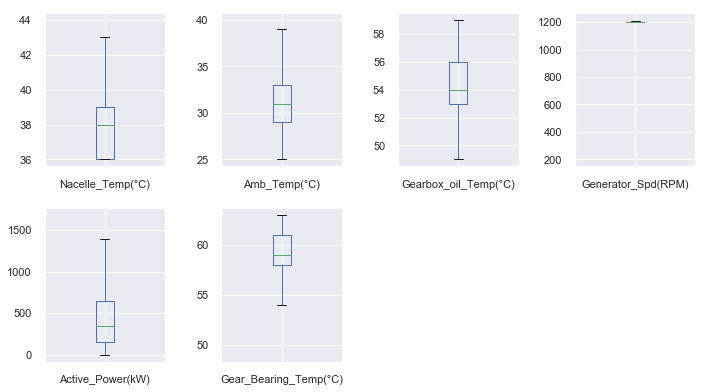

In [91]:
## For the gearbox

gear_cols = ['Nacelle_Temp(°C)','Amb_Temp(°C)','Gearbox_oil_Temp(°C)',
       'Generator_Spd(RPM)','Active_Power(kW)','Gear_Bearing_Temp(°C)']

gear_df_train[gear_cols].plot(kind='box',
            subplots=True,
            layout=(3,4),
            figsize=(10,8),
            sharex=False)

plt.tight_layout()
plt.show()

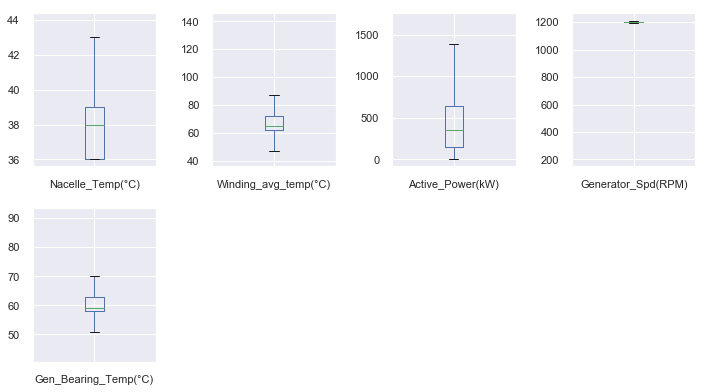

In [92]:
## For the generator

gen_cols = ['Nacelle_Temp(°C)','Winding_avg_temp(°C)','Active_Power(kW)',
             'Generator_Spd(RPM)','Gen_Bearing_Temp(°C)']

gen_df_train[gen_cols].plot(kind='box',
            subplots=True,
            layout=(3,4),
            figsize=(10,8),
            sharex=False)

plt.tight_layout()
plt.show()

Therefore, as can be seen in the graphs, there is no outlier in the training set. Although, one outlier-removing function will be defined:

In [93]:
#Function for outlier removing

def removing_outliers(data_frame, df_cols):
    for i in df_cols:
        q1, q3 = data_frame[i].quantile(0.25), data_frame[i].quantile(0.75)
        iqr = q3 - q1
        data_frame = data_frame.loc[data_frame[i] > q1 - 1.5*iqr]
        data_frame = data_frame.loc[data_frame[i] < q3 + 1.5*iqr]
    return data_frame

### 4.4 Data Scaling

The method of Scheleichtingen and Santos (2011) scale the data using the following equation:

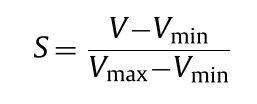

Where V is a variable and S is the normalized variable.

In [94]:
# Defining a data scaling function:

def data_scaling(data_frame, df_cols):
    for j in df_cols:
        a = data_frame[j].max()
        b = data_frame[j].min()
        data_frame[j] = (data_frame[j]-b)/(a-b)
    return data_frame

In [95]:
gear_df_train.describe()

Nacelle_Temp(°C)  Amb_Temp(°C)  Gearbox_oil_Temp(°C)  \
count      11897.000000  11897.000000          11897.000000   
mean          37.980415     30.771035             54.581407   
std            1.637408      2.457615              1.649810   
min           36.000000     25.000000             49.000000   
25%           36.000000     29.000000             53.000000   
50%           38.000000     31.000000             54.000000   
75%           39.000000     33.000000             56.000000   
max           44.000000     40.000000             59.000000   

       Generator_Spd(RPM)  Active_Power(kW)  Gear_Bearing_Temp(°C)  
count        11897.000000      11897.000000           11897.000000  
mean          1199.629150        464.588653              59.338993  
std             30.541316        408.519738               1.627196  
min            200.000000          0.100000              49.000000  
25%           1201.000000        152.300000              58.000000  
50%           1202.000000        350.200000              59.000000  
75%           1204.000000        645.700000              61.000000  
max           1215.000000       1675.600000              63.000000

In [96]:
gen_df_train.describe()

Nacelle_Temp(°C)  Winding_avg_temp(°C)  Active_Power(kW)  \
count      11897.000000          11897.000000      11897.000000   
mean          37.980415             70.735816        464.588653   
std            1.637408             15.570378        408.519738   
min           36.000000             41.000000          0.100000   
25%           36.000000             62.000000        152.300000   
50%           38.000000             65.000000        350.200000   
75%           39.000000             72.000000        645.700000   
max           44.000000            141.000000       1675.600000   

       Generator_Spd(RPM)  Gen_Bearing_Temp(°C)  
count        11897.000000          11897.000000  
mean          1199.629150             61.448432  
std             30.541316              6.206886  
min            200.000000             43.000000  
25%           1201.000000             58.000000  
50%           1202.000000             59.000000  
75%           1204.000000             63.000000  
max           1215.000000             91.000000

In [99]:
#Scaling gearbox and generator data

gear_cols = ['Nacelle_Temp(°C)','Amb_Temp(°C)','Gearbox_oil_Temp(°C)',
           'Generator_Spd(RPM)','Active_Power(kW)']
gen_cols = ['Nacelle_Temp(°C)','Winding_avg_temp(°C)','Active_Power(kW)',
            'Generator_Spd(RPM)']

gear_df_train = data_scaling(gear_df_train, gear_cols)

gen_df_train = data_scaling(gen_df_train, gen_cols)

In [100]:
gear_df_train.describe()

Nacelle_Temp(°C)  Amb_Temp(°C)  Gearbox_oil_Temp(°C)  \
count      11897.000000  11897.000000          11897.000000   
mean           0.247552      0.384736              0.558141   
std            0.204676      0.163841              0.164981   
min            0.000000      0.000000              0.000000   
25%            0.000000      0.266667              0.400000   
50%            0.250000      0.400000              0.500000   
75%            0.375000      0.533333              0.700000   
max            1.000000      1.000000              1.000000   

       Generator_Spd(RPM)  Active_Power(kW)  Gear_Bearing_Temp(°C)  
count        11897.000000      11897.000000           11897.000000  
mean             0.984856          0.277224              59.338993  
std              0.030090          0.243820               1.627196  
min              0.000000          0.000000              49.000000  
25%              0.986207          0.090839              58.000000  
50%              0.987192          0.208953              59.000000  
75%              0.989163          0.385318              61.000000  
max              1.000000          1.000000              63.000000

In [101]:
gen_df_train.describe()

Nacelle_Temp(°C)  Winding_avg_temp(°C)  Active_Power(kW)  \
count      11897.000000          11897.000000      11897.000000   
mean           0.247552              0.297358          0.277224   
std            0.204676              0.155704          0.243820   
min            0.000000              0.000000          0.000000   
25%            0.000000              0.210000          0.090839   
50%            0.250000              0.240000          0.208953   
75%            0.375000              0.310000          0.385318   
max            1.000000              1.000000          1.000000   

       Generator_Spd(RPM)  Gen_Bearing_Temp(°C)  
count        11897.000000          11897.000000  
mean             0.984856             61.448432  
std              0.030090              6.206886  
min              0.000000             43.000000  
25%              0.986207             58.000000  
50%              0.987192             59.000000  
75%              0.989163             63.000000  
max              1.000000             91.000000

## 5.0 Schleichtingen and Santos (2011) model. 

The model proposed by Schlechtingen e Santos (2011) is a feedforward neural network with 5 neurons in the hidden layer, as shows the figure:

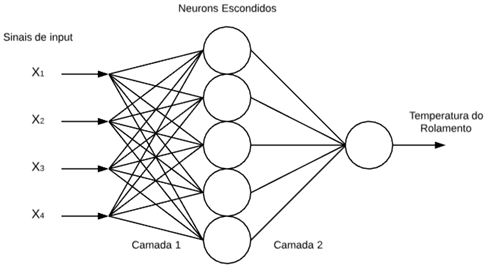

- The input signals are the ones shown in the section 3.3, and the output would be the bearing temperatures for each component.
- The activation function is the Sigmoid Function.
- The Trainging method will be: Gradient Descent with momentum.
- The weights are inicialized radonmly.

### 5.1 For the gearbox bearing

In [115]:
# Defining features and targets

import numpy as np

X = np.array(gear_df_train.drop(['Date/Time','Gear_Bearing_Temp(°C)'], axis=1).copy())
y = np.array(gear_df_train['Gear_Bearing_Temp(°C)'].copy())

In [116]:
# Importing Keras

from keras.models import Sequential
from keras.layers import Dense

In [117]:
# Instantiate de NN model

model_gear = Sequential()
model_gear.add(Dense(10, input_dim = 5, activation = 'sigmoid'))
model_gear.add(Dense(1, activation = 'linear'))

In [118]:


model_gear.compile(loss='mean_squared_error', optimizer = 'adam')

#### 5.1.1 Trainging the Neural Network with gearbox train data

In [119]:
# fitting the model

model_gear.fit(X, y, epochs = 20, batch_size = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
11897/11897 [==============================] - 11s 916us/step - loss: 528.7883
Epoch 2/20
11897/11897 [==============================] - 9s 716us/step - loss: 0.3669
Epoch 3/20
11897/11897 [==============================] - 9s 725us/step - loss: 0.2710
Epoch 4/20
11897/11897 [==============================] - 8s 697us/step - loss: 0.2583
Epoch 5/20
11897/11897 [==============================] - 9s 720us/step - loss: 0.2535
Epoch 6/20
11897/11897 [==============================] - 8s 708us/step - loss: 0.2514
Epoch 7/20
11897/11897 [==============================] - 8s 700us/step - loss: 0.2490
Epoch 8/20
11897/11897 [==============================] - 9s 720us/step - loss: 0.2479
Epoch 9/20
11897/11897 [==============================] - 8s 710us/step - loss: 0.2470
Epoch 10/20
11897/11897 [==============================] - 8s 699us/step - loss: 0.2457
Epoch 11/20
11897/11897 [==============================] - 8s 713us/step - los

In [120]:
# evaluating training loss

loss_gear = model_gear.evaluate(X, y)
print(loss_gear)

11897/11897 [==============================] - 0s 37us/step
0.2387560368175415


#### 5.1.2 Testing the Gearbox Model

In [121]:
# Defining test data

date_training_end = '2013-06-15'

# Test data for the gearbox

gear_df_test = gear_df[gear_df['Date/Time'] > date_training_end].copy()

gear_df_test.tail()

Date/Time  Nacelle_Temp(°C)  Amb_Temp(°C)  \
449936 2019-07-22 13:20:00              38.0          32.0   
449937 2019-07-22 13:30:00              38.0          33.0   
449938 2019-07-22 13:40:00              38.0          32.0   
449939 2019-07-22 13:50:00              38.0          31.0   
449940 2019-07-22 14:00:00              38.0          33.0   

        Gearbox_oil_Temp(°C)  Generator_Spd(RPM)  Active_Power(kW)  \
449936                  57.0              1208.0            1042.7   
449937                  57.0              1204.0             564.3   
449938                  56.0              1205.0             663.1   
449939                  56.0              1205.0             644.9   
449940                  56.0              1205.0             678.3   

        Gear_Bearing_Temp(°C)  
449936                   62.0  
449937                   61.0  
449938                   61.0  
449939                   61.0  
449940                   61.0

In [123]:
# Separating in features and targets

X_test_gear = gear_df_test.drop(['Date/Time','Gear_Bearing_Temp(°C)'], axis=1).copy()
y_test_gear = gear_df_test['Gear_Bearing_Temp(°C)'].copy()

In [125]:
# Data scaling

cols = ['Nacelle_Temp(°C)','Amb_Temp(°C)','Gearbox_oil_Temp(°C)','Generator_Spd(RPM)',
        'Active_Power(kW)']

X_test_gear = data_scaling(X_test_gear, cols)

X_test_gear.describe()

Nacelle_Temp(°C)   Amb_Temp(°C)  Gearbox_oil_Temp(°C)  \
count     277512.000000  277512.000000         277512.000000   
mean           0.642617       0.135346              0.851101   
std            0.043940       0.013581              0.040383   
min            0.000000       0.000000              0.000000   
25%            0.627119       0.124444              0.838710   
50%            0.627119       0.133333              0.854839   
75%            0.644068       0.142222              0.870968   
max            1.000000       1.000000              1.000000   

       Generator_Spd(RPM)  Active_Power(kW)  
count       277512.000000     277512.000000  
mean             0.934624          0.319453  
std              0.195972          0.271762  
min              0.000000          0.000000  
25%              0.986853          0.094883  
50%              0.987675          0.246114  
75%              0.990140          0.480703  
max              1.000000          1.000000

In [126]:
# Previsão escalonada

pred_test_gear = model_gear.predict(X_test_gear)

print(pred_test_gear)

[[61.075348]
 [61.146805]
 [60.991142]
 ...
 [61.72001 ]
 [61.71328 ]
 [61.725952]]


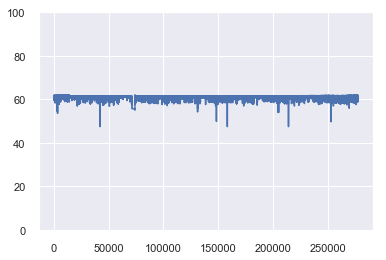

In [147]:
# Gráfico relacionando a temperatura medida e a temperatura modelada

z = np.arange(1, len(pred_test_gear)+1, 1)
y_pred = pred_test_gear

plt.errorbar(z, y_pred)
plt.ylim(0, 100)
plt.show()

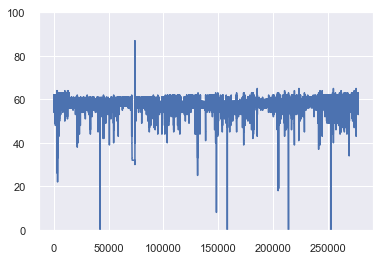

In [148]:
# Real temperature scada Data

y_real = np.array(y_test_gear)

plt.errorbar(z, y_real)
plt.ylim(0, 100)
plt.show()

In [150]:
error = z - y

MemoryError: 

<ErrorbarContainer object of 3 artists>

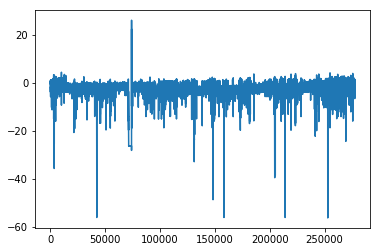

In [172]:
plt.errorbar(z, error)

In [ ]:
def hour_batches_mean(data):
    how_many = len(data)//6
    error_batches = np.ones((how_many, 1))
    for i in range(how_many):
        for j in range(6):
            error_batches[i] += data[6*i + j]
            
            
        error_batches[i] = data[i]/6
    return error_batches